# Initial shape Testing
This file contains code to test whether a cubic spline can be used to initialize the optomizer that solves for a line given endpoints. 
## Current State:
This code does / does not work. 
## Notes:

In [1]:
import numpy as np
import sympy as sym
import scipy
from sympy import *
from scipy.integrate import solve_bvp # solve boundary value problem
from scipy.integrate import solve_ivp # solve initial value problem
from scipy.optimize import minimize
from scipy.linalg import norm
import math
pi = math.pi
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import Image
from math import *
from scipy.interpolate import CubicSpline
from numba import jit, prange

In [2]:
nt = 51
T = 1
dt = T/(nt-1)

In [3]:
def dynamics_2d(t, q, u):
    q1, q2, q3 = q 
    dq1dt = np.cos(q3)
    dq2dt = np.sin(q3)
    dq3dt = u(t)

    dqdt = [dq1dt, dq2dt, dq3dt]
    return dqdt

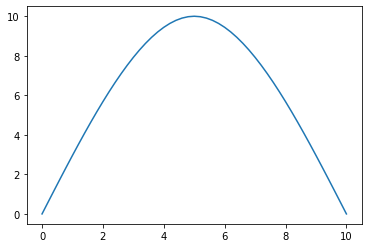

In [22]:
r = 0.5
x = np.linspace(0,10,nt)
x_inter = [0,np.median(x),x[-1]]
# y_inter = [0, np.sqrt(1-np.median(x)),0]
# y_inter = [0, np.sqrt(1-np.median(x))*0.5,0]
y_inter = [0, 10 ,0]
f = CubicSpline(x_inter, y_inter, bc_type='natural')
# f = CubicSpline(x_inter, y_inter, bc_type='clamped')
y = f(x)
plt.plot(x,y)


# #### for theta calculating
# x2 = np.linspace(0,1/pi,(nt+2))
# y2 = f(x2)

In [23]:
###### worked version
theta = np.zeros(nt)
for i in range(nt-1):
    dx = (x[i+1] - x[i])/dt
    dy = (y[i+1] - y[i])/dt
    theta[i] = atan2(dy,dx)
##### u should be size one less than theta, x andy y
u = np.zeros(nt)
for i in range(nt-1):
    u[i] = (theta[i+1] - theta[i])/dt

# print(theta)
# print(u)

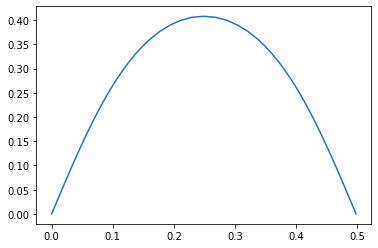

In [24]:
x_sim = np.zeros(len(x))
y_sim = np.zeros(len(y))
theta_sim = np.zeros(len(theta))
for i in range(nt-1):
        if i == 0:
            x_sim[0], y_sim[0], theta_sim[0] = x[0], y[0], theta[0]


        x_sim[i+1] = x_sim[i] +  dt*cos(theta_sim[i])
        y_sim[i+1] = y_sim[i] +  dt*sin(theta_sim[i])
        theta_sim[i+1] = theta_sim[i] + dt*u[i]



plt.plot(x_sim, y_sim)
# plt.plot(x,y)
plt.show()
x_sim2 = x_sim
y_sim2 = y_sim
theta_sim[-1] = theta_sim[-2]

In [25]:
print('x for optimization', x_sim)
print('y for optimization', y_sim)
print('theta for optimization', theta_sim)
print('u for optimization', u)

x for optimization [0.         0.00632759 0.01267347 0.0190562  0.025495   0.03200999
 0.03862265 0.04535621 0.05223612 0.05929074 0.066552   0.07405635
 0.0818459  0.08996987 0.09848647 0.1074652  0.11698988 0.12716227
 0.13810632 0.14997224 0.16293845 0.17720558 0.19296951 0.21034805
 0.22923227 0.24909354 0.26895481 0.28783903 0.30521757 0.3209815
 0.33524863 0.34821484 0.36008076 0.37102481 0.3811972  0.39072188
 0.39970061 0.40821721 0.41634119 0.42413073 0.43163508 0.43889634
 0.44595096 0.45283087 0.45956443 0.46617709 0.47269209 0.47913088
 0.48551361 0.49185949 0.49818708]
y for optimization [ 0.00000000e+00  1.89726533e-02  3.79391999e-02  5.68933731e-02
  7.58285768e-02  9.47376974e-02  1.13612884e-01  1.32445284e-01
  1.51224707e-01  1.69939202e-01  1.88574495e-01  2.07113232e-01
  2.25533953e-01  2.43809648e-01  2.61905713e-01  2.79776985e-01
  2.97363356e-01  3.14583183e-01  3.31323192e-01  3.47422877e-01
  3.62650396e-01  3.76666424e-01  3.88974899e-01  3.98873713e-01
  

In [8]:
dx_check = x_sim[1:] - x_sim[0:-1]
dy_check = y_sim[1:] - y_sim[0:-1]
squ_dcheck = np.sum(dx_check**2 + dy_check**2)

dx_sim = x[1:] - x[0:-1]
dy_sim = y[1:] - y[0:-1]
squ_dsim = np.sum(dx_sim**2 + dy_sim**2)

print('simulated', squ_dcheck)
print('origined', squ_dsim)
print('difference', abs(squ_dcheck - squ_dsim))

simulated 0.019999999999999997
origined 11.596801024000001
difference 11.576801024000002


In [9]:
u = u.reshape((1,nt))
x_sim = x_sim.reshape((1,nt))
y_sim = y_sim.reshape((1,nt))
theta_sim = theta_sim.reshape((1,nt))
state = np.vstack((x_sim,y_sim,theta_sim,u))
state_initials = state
print(state_initials.shape)

start_state = state_initials[0:3,0] 
end_state = state_initials[0:3,-1]

(4, 51)


In [10]:
###### constriants from paper

# @jit(nopython=True)
def system_dynamics(state_initials):
    state_initials = state_initials.reshape((4,nt))
    q = state_initials[0:3,:]

    u = state_initials[-1,:]
    u = u.reshape(1,(nt))
    m,n = u.shape
    
#     error = np.zeros( 3*(nt-1) )
    error = np.zeros( 3*(nt) )
    initial_weight, final_weight = 1,1

    for i in range(nt-1):
        error[3*i] = (q[0, i+1] - q[0,i]) - dt*cos(q[2,i])
        error[3*i+1] = (q[1, i+1] - q[1,i]) - dt*sin(q[2,i])
        error[3*i+2] = (q[2, i+1] - q[2,i]) - dt*u[:,i]
    
#     print('before constriants', error)
        
        
    
#     error_bound = np.zeros(3*(nt-1))
#     error_bound = np.zeros(3*(nt))
#     error_bound[0] =  initial_weight*(q[0,0] - start_state[0])
#     error_bound[1] = initial_weight*(q[1,0] - start_state[1])
#     error_bound[2] = initial_weight*(q[2,0] - start_state[2])
    
#     error_bound[-3] = final_weight*(q[0,-1] - end_state[0])
#     error_bound[-2] = final_weight*(q[1,-1] - end_state[1])
#     error_bound[-1] = final_weight*(q[2,-1] - end_state[2])
    error_initial = np.zeros(3)
#     error[0] = error[0] + initial_weight*(q[0,0] - start_state[0])
#     error[1] = error[1] + initial_weight*(q[1,0] - start_state[1])
#     error[2] = error[2] + initial_weight*(q[2,0] - start_state[2])
    error_initial[0] = initial_weight*(q[0,0] - start_state[0])
    error_initial[1] = initial_weight*(q[1,0] - start_state[1])
    error_initial[2] = initial_weight*(q[2,0] - start_state[2])
    
    error[-3] = error[-3] + final_weight*(q[0,-1] - end_state[0])
    error[-2] = error[-2] + final_weight*(q[1,-1] - end_state[1])
    error[-1] = error[-1] + final_weight*(q[2,-1] - end_state[2])
    
#     print('after constriants', error)
#     print('--------------------------------------')
    error_all = np.concatenate((error_initial, error), axis = None)
    
    
    
#     print(error)
    
#     error_all = np.concatenate((error, error_bound), axis = None)
#     error_all = error + error_bound
#     print(error_all)
#     print('----------------------------------')

    
        
        
#     error[-6] = inital_weight*(q[0,0] - start_state[0])
#     error[-5] = inital_weight*(q[1,0] - start_state[1])
#     error[-4] = inital_weight*(q[2,0] - start_state[2])
         
#     error[-6] = inital_weight*(q[0,0] - 0)
#     error[-5] = inital_weight*(q[1,0] - 0)
#     error[-4] = inital_weight*(q[2,0] - 0)
    
#     error[-3] = final_weight*(q[0,-1] - end_state[0])
#     error[-2] = final_weight*(q[1,-1] - end_state[1])
#     error[-1] = final_weight*(q[2,-1] - end_state[2])
#     print('error', error)
#     print('------------------------------')
    
#     return np.sum(error_all*error_all)
#     print('error', error_all)
    return error_all

In [11]:
# @jit(nopython=True)
def cost_function(state_initials, nt, dt):
    state_initials = state_initials.reshape((4,nt))
    u_cost = state_initials[-1,:]
#     u_cost = state_initials[-1,:]
    running_cost = np.zeros((len(u_cost)))
    
    for i in prange(len(u_cost)):
        running_cost[i] = dt*0.5*(u_cost[i])**2
    cost = np.sum(np.square(running_cost))
    return cost

In [21]:
######################
#optimazation
from time import time

con = ({'type': 'eq', 'fun': system_dynamics})

tic = time()
sol = minimize(cost_function, state, args=(nt, dt), method='slsqp', jac=None, hess=None, hessp=None, bounds=None, constraints=con, tol=1e-9, callback=None, options={'disp':True, 'maxiter': 300})
elasped_time = time() - tic
print("elasped_time: ", elasped_time, "seconds")
opt = sol.x.reshape((4,nt))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.175606895708613
            Iterations: 122
            Function evaluations: 25010
            Gradient evaluations: 122
elasped_time:  15.193351745605469 seconds


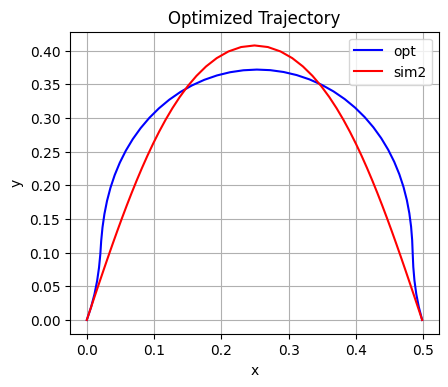

In [18]:
plt.figure(dpi=100,facecolor='w')
plt.plot(opt[0,:],opt[1,:], color = 'b', label="optimized")

plt.plot(x_sim2, y_sim2, color = 'r', label = "sim2")
plt.title('Optimized Trajectory')
plt.gca().set_aspect('equal', adjustable='box')
# plt.axvline(np.median(x_check), color='g', label='axvline - full height')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()


In [15]:
dx_sim = x_sim2[1:] - x_sim2[0:-1]
dy_sim = y_sim2[1:] - y_sim2[0:-1]
squ_dsim = np.sum(dx_sim**2 + dy_sim**2)

xop = opt[0,:]
yop = opt[1,:]
dx_opt = xop[1:] - xop[0:-1]
dy_opt = yop[1:] - yop[0:-1]
squ_dopt = np.sum(dx_opt**2 + dy_opt**2)


print(squ_dopt)
print(squ_dsim)

0.020000000000107328
0.019999999999999997
